# 量子アニーリングで数独を解く
- 数独はグラフ彩色問題とみなすことができる
- グラフ彩色問題は量子アニーリングで効率的に解ける
- dwave社のQUBO solverを使って数独を解いてみる

In [1]:
from dwave_qbsolv import QBSolv
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt

## 数独盤の準備

- 数独のルールに従い準備をする
- peersが重要

In [2]:
n=9 # num of rows
idxs=np.arange(n**2) # num of squares
grid=np.arange(n**2).reshape(n,n)

# list of indices of blocks
block=np.stack([grid[i*3:(i+1)*3,j*3:(j+1)*3].flatten() for i in range(3) for j in range(3)])

# list of indices of row, col, block
unitlist=np.concatenate([grid, grid.T,block])

# list of units. shape 81x3x9
def get_units(s):
    return unitlist[np.isin(unitlist,s).sum(-1).astype(bool)]
units=np.array([get_units(s) for s in range(n**2)])

# list of peers
def get_peers(s):
    a=np.unique(get_units(s))
    idx=a!=s
    return a[idx].tolist()

# peers[i] indicates peers of i-th square.
peers=np.array([get_peers(s) for s in idxs])

## 例題

In [3]:
a= '003020600900305001001806400008102900700000008006708200002609500800203009005010300'

パーサー

In [4]:
digits = np.arange(n)
def parse(grid):
    assert len(grid) == 81
    return np.array([int(c)-1 if c in (digits+1).astype(str) else -1 for c in grid])

# 数独のグラフ表現

- 数独では縦，横，3x3ブロックに属するマスと異なる数字を入れる必要がある
    - これをpeerと呼ぶことにする
- それぞれのマスについて，peerは20個存在する
    - 縦横ブロックそれぞれで8個，重複4個を除いて20
- グラフで表現するには，81個のノードをそれぞれのpeerとつないでやればよい
    - 辺でつながったノード同士は同じ数字を入れることができない
- つまり数独は81ノード，$81 \times 20\ /\ 2 = 810$エッジのグラフ彩色問題とみなせる

描画してみる

In [5]:
g=nx.Graph()

エッジを加える

In [6]:
for i in idxs:
    for j in peers[i]:
        g.add_edge(i,j)

描画

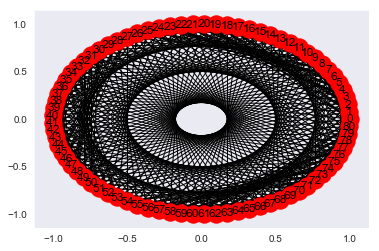

In [7]:
theta=np.arange(n**2)
x=np.cos(2*np.pi*theta/n**2)
y=np.sin(2*np.pi*theta/n**2)
pos={i:(x[i],y[i]) for i in range(n**2)}
nx.draw_networkx(g,pos=pos)

# QUBO行列を作る
- 81x9 = 729のqubit $q_{ij}$で状態を表現する 
    - 第iマスがjのとき，$q_{ij}=1$となり，それ以外の場合は0
- 3種類の制約条件を適用する
    - 1つのマスには1つの数字しか入らない
    $$\sum_j q_{ij} = 1 \tag{1}$$
    - peerのマスとは色が異なる
    - 初期条件

## 第一の制約
- 式(1)をquboに変換するには，(1)が満たされるとき*のみ*最小値を取るようなものを考える
    - これは下のようなエネルギー関数を作ると良い
    $$Ha_i=(1-\sum_j q_{ij})^2$$
    - $q_{ij} \in \{0,1\}$から$q_{ij}^2=q_{ij}$に注意すると，上式は下のようになる
    $$Ha_i=-\sum_j q_{jj}^2 + \sum_{j\neq k}q_{ij}q_{ik} + 1$$
    - 定数項は除いてもよいが，収束判定に使える (今回は数独のルールベースでの判定をするので使わない）
- 今回，qubit $q_{ij}$を81x9の行列として表現しているので，QUBOは(81, 9, 81, 9)のような形にするとわかりやすい
    - あとでQBSolvにわたす形に変換する

In [8]:
alpha=1. # 適当な係数
qubo=np.zeros((n**2,n,n**2,n)) # quboの準備
qubo[range(n**2),:,range(n**2),:] += alpha*(np.ones((n,n))-2*np.eye(n))

# 第二の制約：隣接ノードを異なる数字にする
- iマスとjマスが同じpeerにいるとき，$q_{ik}\neq q_{jk}$となってほしい
- これは$q_{ik}q_{jk}$をエネルギー関数とすれば良い
    - マスに入る数字が異なれば0，同じならば1となるので，異なるときのみ最小値を取る

In [9]:
# さっき作ったグラフをつかう
for i,j in g.edges:
    qubo[i,range(n),j,range(n)]+=1

# 第三の制約：初期条件
- iマスの初期値がjならば，$-q_{ij}$をエネルギー関数とすれば良い
    - 初期値を満たすときのみ最小値-1を取る

In [10]:
# 問題aの初期値
init_values=parse(a)

In [11]:
beta=10.
for i in np.where(init_values>=0)[0]:
    j=init_values[i]
    if j >= 0:
        qubo[i,j,i,j]=-beta

# QUBO行列を適当な形式に変換する
- QBSolvにわたすときは，{(i,j): Q[i,j]}のように辞書で渡す

In [12]:
idx=np.unravel_index(np.arange(n**2*n),(n**2,n))
_Q=qubo[idx[0],idx[1],:,:]
_Q=_Q[:,idx[0],idx[1]]

In [13]:
Q={}
for i in zip(*np.nonzero(_Q)):
    Q[i]=_Q[i]

# QBSolverで解く
- 先程作ったqubo行列`Q`を渡せば良い
- 一行で解ける！

In [14]:
res=QBSolv().sample_qubo(Q)

In [15]:
def get_answer(init_values, dct):
    x=np.full((n**2,n),-1)
    y=np.full(n**3,-1)
    y[list(dct.keys())]=np.array(list(dct.values()))
    x[idx]=y
    values=x @ np.arange(n)
    values[init_values>=0]=init_values[init_values>=0]
    return values

In [16]:
answer=get_answer(init_values,list(res.samples())[0])

結果判定

In [17]:
def check_answer(answer):
    # 埋められていないマス(=-1)があるならば不正解
    if np.min(answer)<0:
        return False
    # すべてのマスがpeersと異なるならば正解
    return (answer[peers]-answer[:,None] == 0).sum() == 0
print(check_answer(answer))

True


とけた!

# 結果の出力

In [18]:
def display(values):
    x=values.reshape(n,n)
    line = "-"*19
    for r in range(n):
        print(*list(str(int(x[r,c])+1)+('|' if c == 2 or c == 5 else '') for c in range(n)))
        if r == 2 or r==5: print(line)

In [19]:
display(answer)

4 8 3| 9 2 1| 6 5 7
9 6 7| 3 4 5| 8 2 1
2 5 1| 8 7 6| 4 9 3
-------------------
5 4 8| 1 3 2| 9 7 6
7 2 9| 5 6 4| 1 3 8
1 3 6| 7 9 8| 2 4 5
-------------------
3 7 2| 6 8 9| 5 1 4
8 1 4| 2 5 3| 7 6 9
6 9 5| 4 1 7| 3 8 2


# おわり
- 難しい数独になると，ハイパーパラメータをきちんと調整しないと失敗するかもしれません